# Sreeni U-NET model

### Check for GPU

In [1]:
import tensorflow as tf

# List all physical GPU devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected by TensorFlow:", gpus)
# Print the default GPU device name, if any
if gpus:
    print("Default GPU device:", tf.test.gpu_device_name())
else:
    print("No GPU available to TensorFlow.")


2025-08-22 22:48:57.498643: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-22 22:48:57.617360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755895737.662440   34568 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755895737.677635   34568 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755895737.791119   34568 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs detected by TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU device: /device:GPU:0


I0000 00:00:1755895740.625286   34568 gpu_device.cc:2019] Created device /device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Imports

In [2]:
from keras.utils import normalize, to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import os
import glob
import cv2

import numpy as np
from matplotlib import pyplot as plt
import random

In [3]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256

# Define a mapping from RGB colors to class labels
COLOR_MAP = {
    (0, 0, 0): 0,        # Black -> Background (Class 0)
    (128, 128, 128): 1,  # Gray -> Roads (Class 1), Buriny
    (255, 0, 0): 2,      # Red -> Rodents (Class 2)
    (0,255,0): 3,        # Green -> Forests (Class 3)
}
n_classes= len(COLOR_MAP) #Number of classes for segmentation
print(n_classes)

dataset_path = "../data/dataset"
train_images_path = os.path.join(dataset_path, "train/images")
train_masks_path = os.path.join(dataset_path, "train/masks")

4


## Load data

In [4]:
# Capture training image info as a sorted list
train_images = []
image_paths = sorted(glob.glob(os.path.join(train_images_path, "*.tif")))  # ✅ Sort images

for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    train_images.append(img)

train_images = np.array(train_images)

# Capture mask/label info as a sorted list
train_masks = []
mask_paths = sorted(glob.glob(os.path.join(train_masks_path, "*.tif")))  # ✅ Sort masks

for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    train_masks.append(mask)

train_masks = np.array(train_masks)

# Debugging: Print first 5 paths to check alignment
print("First 5 Image Paths:", image_paths[:5])
print("First 5 Mask Paths:", mask_paths[:5])

# Shape check
print("Train Images Shape:", train_images.shape)  # Expected: (num_samples, height, width, channels)
print("Train Masks Shape:", train_masks.shape)  # Expected: (num_samples, height, width, channels)


First 5 Image Paths: ['../data/dataset/train/images/Buriny.tif_patch_10_107.tif', '../data/dataset/train/images/Buriny.tif_patch_10_113.tif', '../data/dataset/train/images/Buriny.tif_patch_10_114.tif', '../data/dataset/train/images/Buriny.tif_patch_10_116.tif', '../data/dataset/train/images/Buriny.tif_patch_10_13.tif']
First 5 Mask Paths: ['../data/dataset/train/masks/Buriny.tif_patch_10_107.tif', '../data/dataset/train/masks/Buriny.tif_patch_10_113.tif', '../data/dataset/train/masks/Buriny.tif_patch_10_114.tif', '../data/dataset/train/masks/Buriny.tif_patch_10_116.tif', '../data/dataset/train/masks/Buriny.tif_patch_10_13.tif']
Train Images Shape: (1459, 256, 256, 3)
Train Masks Shape: (1459, 256, 256)


In [5]:
def decode_mask(mask):
    """
    Convert a class-index mask to an RGB image for visualization.

    Args:
        mask (numpy array): A 2D array with class labels (H, W)

    Returns:
        numpy array: An (H, W, 3) RGB image
    """
    h, w = mask.shape  # Get height & width
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)  # Initialize RGB mask

    # Assign RGB colors correctly using broadcasting
    for rgb, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = np.array(rgb, dtype=np.uint8)  # Assign RGB color

    return rgb_mask


## Normalize and set dimensions

In [6]:
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks, axis=3)

print("Train Images Shape:", train_images.shape)  # Expected: (num_samples, height, width, channels)
print("Train Masks Shape:", train_masks_input.shape)  # Expected: (num_samples, height, width, channels)

Train Images Shape: (1459, 256, 256, 3)
Train Masks Shape: (1459, 256, 256, 1)


## Data splits

In [7]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are ...  [0 1]


In [8]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # just to be sure

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes)) # just to be sure

## Class weights

In [10]:
# Flatten the mask array to 1D
train_masks_flat= train_masks.flatten()

# Compute class weights
class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_masks_flat),
    y=train_masks_flat
)

print("Class weights are:", class_weights_values)

# Convert to dictionary (required for model.fit)
class_weights = {i: class_weights_values[i] for i in range(len(class_weights_values))}
print("Class Weights:", class_weights)

Class weights are: [1.09675728 0.91893079]
Class Weights: {0: 1.0967572826055487, 1: 0.9189307902677876}


## Model definition

In [11]:
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""

################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions

    return model

## Model compilation

In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1755896236.076458   34568 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,156 (7.40 MB)

 Trainable params: 1,941,156 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## Fit model

In [13]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test_cat),
                    # class_weight=class_weights,
                    )

Epoch 1/20


/home/ramexvpn/miniconda3/envs/unet/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1755896259.143578   36427 service.cc:152] XLA service 0x7fa268037af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755896259.144534   36427 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-08-22 22:57:39.260562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755896259.823872   36427 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1755896270.229392   36427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the

132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.5254 - loss: 0.9066 - val_accuracy: 0.5371 - val_loss: 0.6648
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5905 - loss: 0.6616 - val_accuracy: 0.4867 - val_loss: 0.6642
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6056 - loss: 0.6403 - val_accuracy: 0.8207 - val_loss: 0.4378
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8252 - loss: 0.4148 - val_accuracy: 0.8497 - val_loss: 0.3578
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8544 - loss: 0.3455 - val_accuracy: 0.8638 - val_loss: 0.3287
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8534 - loss: 0.3418 - val_accuracy: 0.8572 - val_loss: 0.3424
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8582 - loss: 0.3373 - val_accuracy: 0.8667 - val_loss: 0.3349
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8664 - loss: 0.3103 - val_accuracy: 0.8

In [14]:
model.save('../data/models/unet_model_multiclass_buriny.keras')

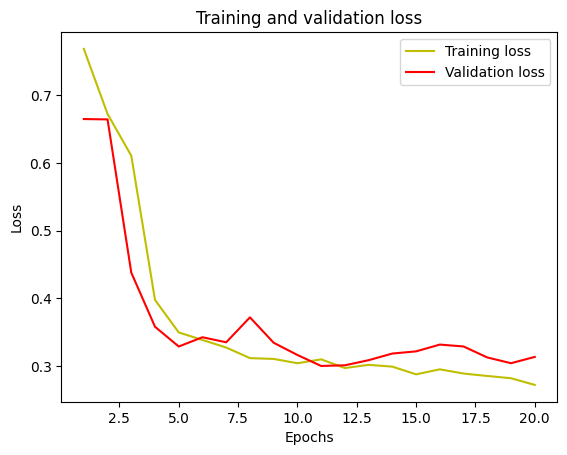

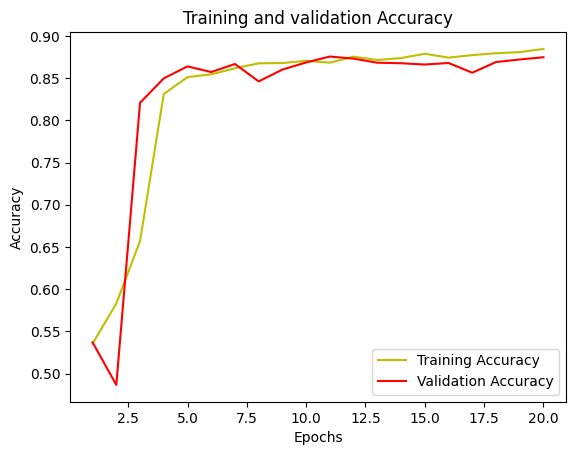

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


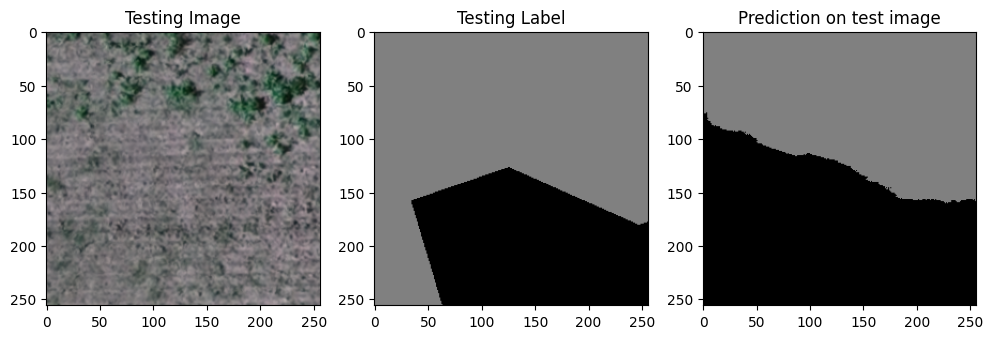

In [18]:

# Randomly select a test image
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]  # Get test image

ground_truth = y_test[test_img_number]  # Get ground truth mask
ground_truth = np.squeeze(ground_truth, axis=-1)

test_img_input = np.expand_dims(test_img, axis=0)  # Add batch dimension

# Predict segmentation mask
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)  # Convert softmax to class labels
predicted_img = predicted_img.squeeze(0)  # Now shape is (256, 256)

# Convert ground truth and prediction to RGB (if needed)
ground_truth_rgb = decode_mask(ground_truth)  # Convert label mask to RGB
predicted_rgb = decode_mask(predicted_img)

# # Plot results
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow((test_img * 255*7).astype(np.uint8))  # Show original image

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_rgb)  # Show true segmentation mask in RGB

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_rgb)  # Show predicted segmentation mask in RGB

# plt.show()